In [2]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

In [3]:
receptor = 'TRMD'#AR B2AR CDK2 CHK1 HSP90 LPXC TRMD

data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'

xrmsd_file = 'xrmsd.csv'
xglide_dir = data_set_dir + 'xglide/'
crystal_fp_file = data_set_dir + '/ifp/crystal_ifp_2/ifp.fp'
xdocking_fp_dir = data_set_dir + '/ifp/xglide_ifp_2/'

In [4]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints

#(all_crystals, all_glides) = load_data(
#    data_set_dir, rmsd_file, glide_dir, crystal_fp_file, docking_fp_dir,w=w2)
(all_xcrystals, all_xglides) = load_data(
    data_set_dir, xrmsd_file, xglide_dir, crystal_fp_file, xdocking_fp_dir,w=[10,10,10,1,0])

Loading crystal structures...
Loading glidescores...
424 of 690 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


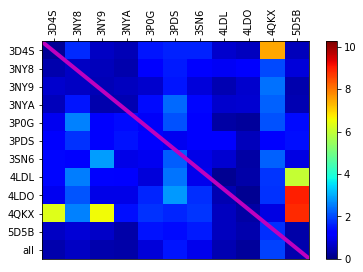

0.748909090909


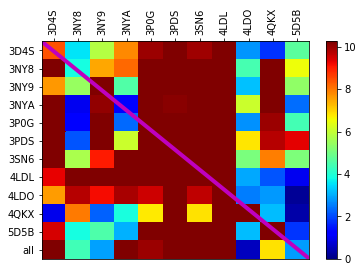

got lucky on 1 of 132 pairs.


In [4]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

ligs = sorted(all_xglides.keys())#['4LDL','4LDO','4QKX'] # ['3P0G','4LDL','4LDO','4QKX','3PDS']
structs = []
for l in ligs:
    structs.extend([i for i in all_xglides[l] if i not in structs])
structs.sort()

n = 25

xglides = {l:{s:all_xglides[l][s] for s in all_xglides[l] if s in structs} for l in all_xglides if l in ligs}
xcrystals = {s:all_xcrystals[s] for s in all_xcrystals}

all_poses = refine_poses(xglides, require_fp=False)
for lig in ligs:
    xglides[lig]['all'] = Ligand(None)
    xglides[lig]['all'].poses = {i:all_poses[lig][i] for i in range(len(all_poses[lig]))}
    
structs.append('all')

get_ipython().magic(u'matplotlib inline')

best_rmsd_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: np.min(x) if x != [] else np.nan)
heatmap(best_rmsd_matrix, ligs, structs)
print np.nanmean(best_rmsd_matrix[-1][:])

var_mat = get_docking_stats(ligs, structs, xglides, n, lambda x: np.var(x) if x != [] else np.nan)
heatmap(var_mat, ligs, structs)

helpfully_frozen(ligs, structs, xglides, n)

In [ ]:
get_ipython().magic(u'matplotlib inline')

for lig in ligs:
    print lig
    
    for struct in structs:
        if struct not in xglides[lig]: continue
        #print 'lig, struct: ', lig, struct
        poses = xglides[lig][struct].poses
        pnum = [i for i in poses.keys()]
        g1 = [i for i in poses.keys()]
        rmsd = [poses[i].rmsd for i in poses.keys()]
        plt.plot(g1[:n], rmsd[:n], '.', markersize=10)
        #plt.plot(rmsd[:50], 'b.', markersize=10)
        print 'rmsd mean: ', np.mean(rmsd[:n])
        print 'rmsd var: ', np.var(rmsd[:n])
        #if struct in xglides[lig].keys():
        #    p2 = xglides[lig][struct].poses
        #    pnum2 = [i for i in p2.keys()]
        #    g2 = [i for i in p2.keys()]
        #    r2 = [p2[i].rmsd for i in p2.keys()]
        #    plt.plot(g2[:25],r2[:25], 'b.', markersize=10)
            #plt.plot(r2[:50], 'r.', markersize=10)
            #print 'rmsd mean (red): ', np.mean(r2[:25])
            #print 'rmsd var (red): ', np.var(r2[:25])
            
        plt.gca().set_ylim([0,15])
        plt.gca().set_xlim([0,25])
        plt.show()

In [5]:
for l in xglides:
    for s in xglides[l]:
        for p in xglides[l][s].poses:
            for r in xglides[l][s].poses[p].fp.feats:
                if r > 1000:
                    xglides[l][s].poses[p].fp.feats[str(int(r) - 1000)] = xglides[l][s].poses[p].fp.feats[r]
                    del xglides[l][s].poses[p].fp.feats[r]
                    
for s in xcrystals:
    for r in xcrystals[s].fp.feats:
        if r > 1000:
            xcrystals[s].fp.feats[str(int(r) - 1000)] = xglides[l][s].poses[p].fp.feats[r]
            del xcrystals[s].fp.feats[r]

In [ ]:
print xcrystals.keys()

all


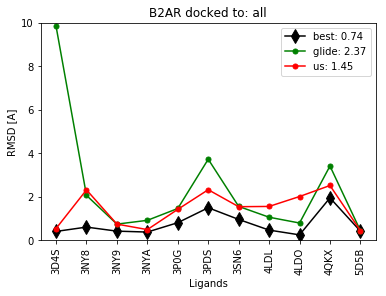

In [6]:
## STEP 4:
## score all pairs of ligands
#print glides.keys()
#best_rmsd_matrix = best_pose(glides.keys(), glides.keys(), glides, 50)
#best_rmsd_matrix2 = best_pose(xglides.keys(), xglides.keys(), xglides, 25)
us_final = []
glide_final = []
for struct in ['all']:#structs:
    print struct
    
    scores = Scores(xglides, xcrystals, ligs, struct, n)
    final_rmsds = plot_final_rmsds(scores, receptor+' docked to: '+struct)#, scores,'old dock: ')
    if struct == 'all': continue
    us_final.extend([i[1] for i in final_rmsds])
    glide_final.extend([i[3] for i in final_rmsds])

In [ ]:
# randomly pick a ligand
# optimize that ligand

#pose_cluster = [(l, np.argmax(scores.get_final_scores(l)[:-1])) for l in scores.ligands] + [(l, -1) for l in xcrystals if l not in scores.ligands]
#print pose_cluster
pose_cluster = [i for i in pose_cluster]
print np.mean([ scores.get_rmsds(l)[pose_cluster[scores.ligands.index(l)][1]] for l in scores.ligands ])
for sample in range(150):
    rand_lig = np.random.choice(scores.ligands)
    lig_ind = scores.ligands.index(rand_lig)
    
    old_rmsd = scores.get_rmsds(rand_lig)[pose_cluster[lig_ind][1]]
    
    (max_score, pose_num) = (0, 0)
    for p in range(scores.num_poses[rand_lig]):
        pose_cluster[lig_ind] = (rand_lig, p)
        new_score = objective(scores, pose_cluster)
        if new_score > max_score:
            max_score, pose_num = new_score, p
    pose_cluster[lig_ind] = (rand_lig, pose_num)
    
    new_rmsd = scores.get_rmsds(rand_lig)[pose_cluster[lig_ind][1]]
    
    if new_rmsd != old_rmsd:
        print '{} updated: {} -> {}'.format(rand_lig, old_rmsd, new_rmsd)
        print np.mean([ scores.get_rmsds(l)[pose_cluster[scores.ligands.index(l)][1]] for l in scores.ligands ])

In [ ]:
print np.mean([ scores.get_rmsds(l)[pose_cluster[scores.ligands.index(l)][1]] for l in scores.ligands ])

In [ ]:
for bad_lig in scores.ligands:
    print bad_lig
    pose_cluster = [(l, np.argmax(scores.get_final_scores(l)[:-1])) for l in scores.ligands]
    bad_ind = scores.ligands.index(bad_lig)
    rmsds = scores.get_rmsds(bad_lig)
    #print rmsds[pose_cluster[bad_ind][1]]
    plt.plot([rmsds[pose_cluster[bad_ind][1]]],[objective(scores, pose_cluster)], '*')
    for p in scores.num_poses[rand_lig]:
        try:
            pose_cluster[bad_ind] = (bad_lig, p)
            plt.plot([rmsds[pose_cluster[bad_ind][1]]],[objective(scores, pose_cluster)], '.')
        except: pass
    plt.gca().set_xlim([0,12])
    plt.show()
    #print pose_cluster

In [ ]:
def objective(scores, pose_cluster):
    score = 0
    for l1, p1 in pose_cluster:
        for l2, p2 in pose_cluster:
            if l1 == l2: continue
            if p1 == -1: fp1 = scores.crystals[l1].fp
            else: fp1 = scores.glides[l1][scores.struct].poses[p1].fp
            if p2 == -1: fp2 = scores.crystals[l2].fp
            else: fp2 = scores.glides[l2][scores.struct].poses[p2].fp
            score += scores.score_pose_pair(fp1, fp2)
    return score

In [ ]:
plt.plot(us_final, glide_final, '.')
plt.gca().set_xlim([0,14])
plt.gca().set_ylim([0,14])
plt.gca().set_xlabel('us')
plt.gca().set_ylabel('glide')
plt.show()

print 'average rmsd across all structures: {} for us, {} for glide'.format(np.mean(us_final), np.mean(glide_final))

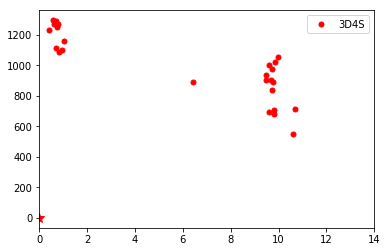

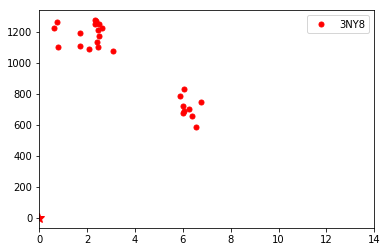

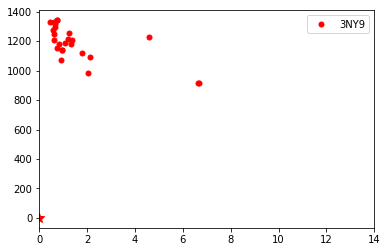

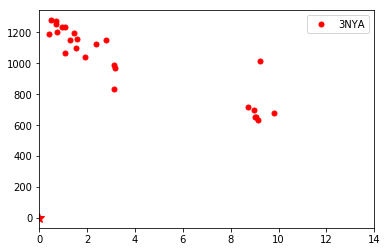

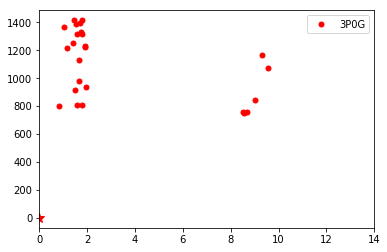

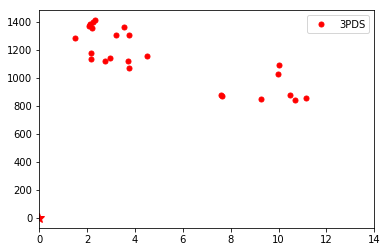

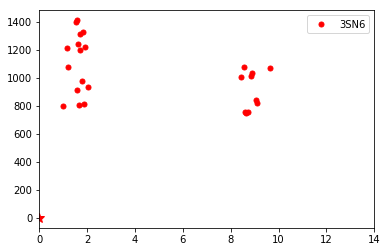

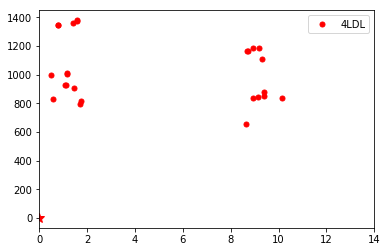

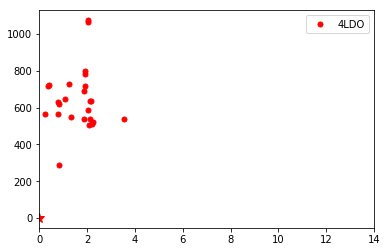

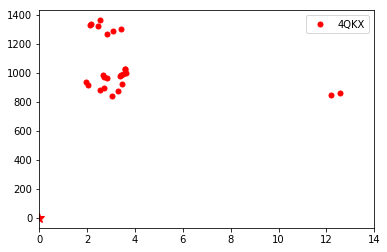

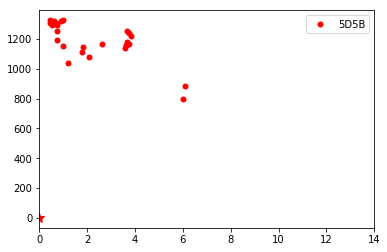

In [7]:
for lig in ligs:
    plot_scores_vs_rmsds(lig, scores, lab=lig)#, scores2=scores, lab2='old dock')

In [ ]:
(l1,l2,l3) = ('4FSW','4FSZ','4FT0')#tuple(ligs)[:3]
for struct in ['all']:#structs[3:6]:
    for p1 in range(25):
        print p1
        f1 = xglides[l1][struct].poses[p1]
        for p2 in range(25):
            f2 = xglides[l2][struct].poses[p2]
            for p3 in range(25):
                f3 = xglides[l3][struct].poses[p3]
                score = scores.score_pose_pair(f1.fp,f2.fp)+scores.score_pose_pair(f3.fp,f2.fp)+scores.score_pose_pair(f1.fp,f3.fp)
                r = (f1.rmsd+f2.rmsd+f3.rmsd)/3
                plt.plot([r],[score],'.k')
    plt.show()

In [ ]:
(l1,l2,l3) = tuple(ligs)
for struct in structs:
    fig, ax = plt.subplots()
    print struct
    for p1 in range(25):
        print p1
        f1 = glides[l1][struct].poses[p1]
        for p2 in range(25):
            f2 = glides[l2][struct].poses[p2]
            s1 = scores.score_pose_pair(f1.fp,f2.fp)
            for p3 in range(25):
                f3 = glides[l3][struct].poses[p3]
                score = s1+scores.score_pose_pair(f3.fp,f2.fp)+scores.score_pose_pair(f1.fp,f3.fp)
                r = (f1.rmsd+f2.rmsd+f3.rmsd)/3
                plt.plot([r],[score],'.k')
                ax.set_title(struct+' struct objective')

    plt.show()

In [ ]:
(worst_lig, worst_rmsd, b, c) = final_rmsds[np.argmax([i[1] for i in final_rmsds])]
print worst_lig, worst_rmsd, b, c

In [ ]:
#worst_lig = '4YKU'

for worst_lig in ['MAP17']:#filtered_ligands:
    print worst_lig
    final_scores = scores.get_final_scores(worst_lig)[:-1]
    rmsds = scores.get_rmsds(worst_lig)[:-1]

    top_pose = np.argmax(final_scores)
    best_pose = np.argmin(rmsds)

    print 'Top pose: ' + str(top_pose) + '. Score: ' + str(final_scores[top_pose]) + '. RMSD: ' + str(rmsds[top_pose])
    print 'Best pose: ' + str(best_pose) + '. Score: ' + str(final_scores[best_pose]) + '. RMSD: ' + str(rmsds[best_pose])
    print 'Crystal pose score: ' + str(scores.get_final_scores(worst_lig)[-1])

#print rmsds
#print [glides[worst_lig][best_structure].poses[i].rmsd for i in range(50)]

In [ ]:
#worst_lig='4FSW'

## STEP 6:
## look at the final scores for all poses of the worst ligand

## for our method to work repeatably and reliably,
## there needs to be a strong correlation in these plots

plot_scores_vs_rmsds(worst_lig, scores, lab=worst_lig)#, scores2=scores2, lab2='new h')

In [ ]:
fp = xglides[worst_lig][struct].poses[best_pose].fp.feats

for res in sorted(map(int,fp.keys())):
    thresh = [i**2 if i**2 > 1 else 0 for i in fp[str(res)]]
    if any(thresh):
        print res, thresh

In [ ]:
fp = xglides[worst_lig][struct].poses[top_pose].fp.feats

for res in sorted(map(int,fp.keys())):
    thresh = [i**2 if i**2 > 1 else 0 for i in fp[str(res)]]
    if any(thresh):
        print res, thresh

In [ ]:
fp = crystals[worst_lig].fp.feats

for res in sorted(fp.keys()):
    print res, [i if abs(i) > 0.1 else 0 for i in fp[res]]

In [ ]:
## STEP 3:
## pick 1 receptor structure to use for all ligands
## filter ligands that are poorly docked

#rmsd_filter = lambda x: x < 2
#best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, glides.keys())
#print best_structure
best_structure = '4YKQ'#highest_diam_ligand
struct_ind = glides.keys().index(best_structure)
filtered_ligands = [glides.keys()[i] for i in range(len(glides.keys())) if not np.isnan(best_rmsd_matrix[struct_ind][i])]

struct_ind2 = xglides.keys().index(best_structure)
filtered_ligands2 = [xglides.keys()[i] for i in range(len(xglides.keys())) if not np.isnan(best_rmsd_matrix[struct_ind2][i])]

print 'The best structure is ' + best_structure
print str(len(filtered_ligands)) + ' of ' + str(len(glides.keys())) + ' ligands were docked:'
print filtered_ligands
print 'with an average best rmsd of ' + str(np.nanmean(best_rmsd_matrix))[:5]

In [ ]:
## STEP 7: 
## look through pairs involving worst_lig

l1 = worst_lig
#(l2, next_worst_rmsd, b, c) = final_rmsds[np.argmax([i[1] if i[1] != worst_rmsd else 0 for i in final_rmsds])]
l2 = '3V49'
print l1, l2

In [ ]:
## STEP 8: debug the worst pair

get_ipython().magic(u'matplotlib inline')

plot_all_poses('3V4A', '3V49', scores, 'ugh')#, scores2, 'new')

In [ ]:
## use this block to extract interesting pairs from the plot above

# l1 pose num, l2 pose num, rmsd1, rmsd2, score

bad_rmsd = lambda r1,r2: (r1+r2)/2.0 >= 2
good_rmsd = lambda r1,r2: (r1+r2)/2.0 <= 2
good_score = lambda score: score >= 50
combo = lambda rmsd, score: score and rmsd

# output: p1, p2, r1, r2, score(p1,p2)
bad_pairs = scores.get_filtered_pose_pairs(l1, l2, bad_rmsd, good_score, combo)
bad_pairs.sort(key=lambda x: x[4])
bad_pairs.reverse()

good_pairs = scores.get_filtered_pose_pairs(l1, l2, good_rmsd, good_score, combo)
good_pairs.sort(key=lambda x: x[4])
good_pairs.reverse()

print l1, l2
print 'Bad pairs:'
for i in range(min(5, len(bad_pairs))):
    print bad_pairs[i]
print 'Good pairs:'
for i in range(min(5, len(good_pairs))):
    print good_pairs[i]

In [ ]:
(bad_score,  bad_interactions)  = scores.get_interactions(l1, l2, bad_pairs[0][0],  bad_pairs[0][1])
(good_score, good_interactions) = scores.get_interactions(l1, l2, good_pairs[0][0], good_pairs[0][1])
(true_score, true_interactions) = scores.get_interactions(l1, l2, -1, -1)

# returns list of tuples: (arg1_strength - arg2_strenth, res, interaction_type)
explore_1 = scores.find_mismatched_interactions(true_interactions, good_interactions)
explore_2 = scores.find_mismatched_interactions(true_interactions, bad_interactions)

explore_1.sort(key=lambda x: abs(x[0]), reverse=True) # sort on absolute value of the mismatch
explore_2.sort(key=lambda x: x[0])

print 'Biggest mismatches between the good pose and the crystal pose'
for i in range(10):
    print explore_1[i]
print '--------'
print 'Biggest negative mismatches between the bad pose and the crystal pose'
for i in range(10):
    print explore_2[i]

In [ ]:
#print crystals.keys()
for res in crystals['3V4A'].fp.feats.keys():
    print res, [i if abs(i) > .01 else 0 for i in crystals['3V4A'].fp.feats[res]]